# Import dependencies 

In [140]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import pandas as pd
import glob

api = KaggleApi()
api.authenticate()

dataset_ref = 'ashish2693/automobile-data-exploration-sl'
download_path = '../data/raw'

os.makedirs(download_path, exist_ok=True)
api.dataset_download_files(dataset_ref, path=download_path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/ashish2693/automobile-data-exploration-sl


### Let's predict mpg (miles per gallon) based on multiple features using Gradient Descent

# EDA

In [141]:
csv_files = glob.glob(os.path.join(download_path, "mtcars.csv"))
df = pd.read_csv(csv_files[0])
df.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   model   32 non-null     object 
 1   mpg     32 non-null     float64
 2   cyl     32 non-null     int64  
 3   disp    32 non-null     float64
 4   hp      32 non-null     int64  
 5   drat    32 non-null     float64
 6   wt      32 non-null     float64
 7   qsec    32 non-null     float64
 8   vs      32 non-null     int64  
 9   am      32 non-null     int64  
 10  gear    32 non-null     int64  
 11  carb    32 non-null     int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 3.1+ KB


This dataset is not big enough to pick GD as the right optimization algorithm but here we are for a simple implementation

In [143]:
df.describe()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0000
mean,20.090625,6.187500,230.721875,146.687500,3.596563,3.217250,17.848750,0.437500,0.406250,3.687500,2.8125
std,6.026948,1.785922,123.938694,68.562868,0.534679,0.978457,1.786943,0.504016,0.498991,0.737804,1.6152
min,10.400000,4.000000,71.100000,52.000000,2.760000,1.513000,14.500000,0.000000,0.000000,3.000000,1.0000
25%,15.425000,4.000000,120.825000,96.500000,3.080000,2.581250,16.892500,0.000000,0.000000,3.000000,2.0000
50%,19.200000,6.000000,196.300000,123.000000,3.695000,3.325000,17.710000,0.000000,0.000000,4.000000,2.0000
75%,22.800000,8.000000,326.000000,180.000000,3.920000,3.610000,18.900000,1.000000,1.000000,4.000000,4.0000
max,33.900000,8.000000,472.000000,335.000000,4.930000,5.424000,22.900000,1.000000,1.000000,5.000000,8.0000


In [144]:
print(f"Duplicates: {df.duplicated().sum()}")
print(f"Nulls per column:\n{df.isnull().sum()}")
print(f"\nUnique values per column:\n{df.nunique()}")

Duplicates: 0
Nulls per column:
model    0
mpg      0
cyl      0
disp     0
hp       0
drat     0
wt       0
qsec     0
vs       0
am       0
gear     0
carb     0
dtype: int64

Unique values per column:
model    32
mpg      25
cyl       3
disp     27
hp       22
drat     22
wt       29
qsec     30
vs        2
am        2
gear      3
carb      6
dtype: int64


The data is squeaky clean, no duplicates and no nulls at all. Only 32 rows though, which is really small, especially when we have 12 columns. With this ratio of samples to features, overfitting is a real concern. 

The vs and am columns only have 2 unique values each so they're basically binary flags (engine shape and transmission type). Cyl and gear only have 3 unique values but they work fine as numeric for linear regression.

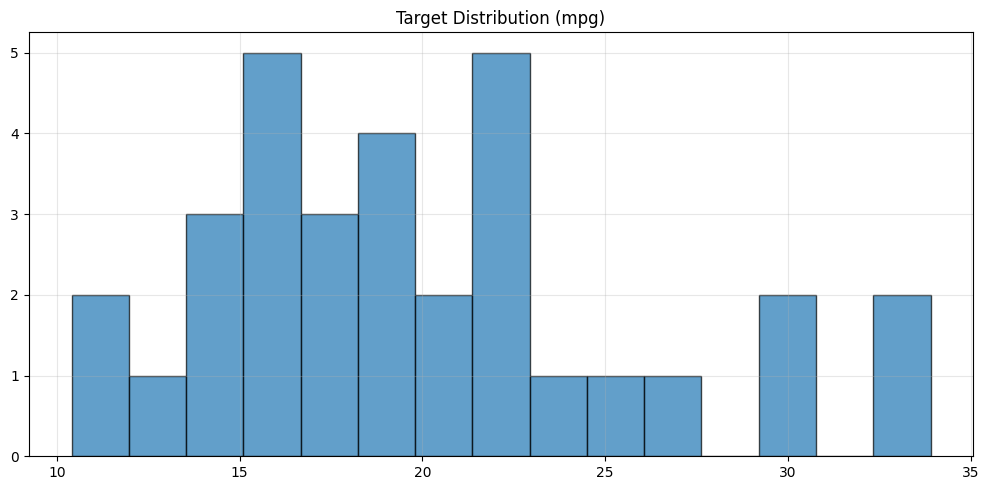

Skewness: 0.64
Kurtosis: -0.20


In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

y = df['mpg']

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y, bins=15, edgecolor='k', alpha=0.7)
ax.set_title('Target Distribution (mpg)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Skewness: {skew(y):.2f}")
print(f"Kurtosis: {kurtosis(y):.2f}")

Skewness of 0.64 means there's a slight right skew, a few cars pull the tail to the high-mpg side. But 0.64 is still within the acceptable range (under 1) so no transform needed right now. 

Kurtosis at -0.20 is technically platykurtic but very close to normal, no crazy outlier-driven spikes in the distribution. We can use raw mpg as the target without any log transform or anything. If the residuals look weird later, we can revisit this.

In [146]:
# Outlier detection using Z-score on the (in this case all of them) numerical features
from scipy import stats

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
z_scores = np.abs(stats.zscore(df[numeric_cols]))
outlier_rows = (z_scores > 3).any(axis=1)
print(f"Outlier rows (Z > 3): {outlier_rows.sum()} / {len(df)}")
if outlier_rows.sum() > 0:
    print(df[outlier_rows][['model', 'mpg', 'hp', 'disp', 'wt']])

Outlier rows (Z > 3): 1 / 32
            model   mpg   hp   disp    wt
30  Maserati Bora  15.0  335  301.0  3.57


Found one outlier: the Maserati Bora with 335 hp. That's way above every other car in the dataset (the next highest is around 245). But its mpg of 15.0 is totally normal for the target range, so it's not going to yank the regression line in a weird direction. 

Keeping it for now. After we train the model we'll check if it has a huge residual or a high Cook's distance, and if so, we'll remove it and retrain

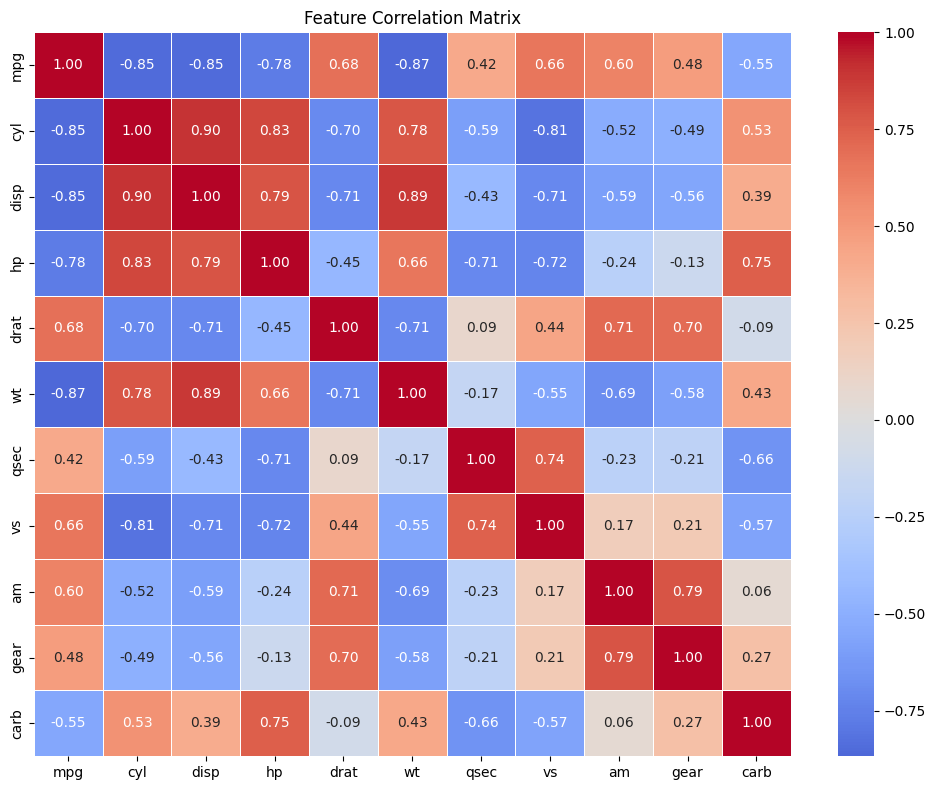


Correlation with target (mpg):
drat    0.681172
vs      0.664039
am      0.599832
gear    0.480285
qsec    0.418684
carb   -0.550925
hp     -0.776168
disp   -0.847551
cyl    -0.852162
wt     -0.867659
Name: mpg, dtype: float64


In [147]:
# Correlation matrix
import seaborn as sns

corr = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nCorrelation with target (mpg):")
print(corr['mpg'].drop('mpg').sort_values(ascending=False))

The correlation matrix paints a clear picture. The strongest predictors of mpg are wt (-0.87), cyl (-0.85), disp (-0.85), and hp (-0.78). All negative, which makes sense: heavier, bigger-engined, more powerful cars burn more fuel. On the positive side, drat (0.68), vs (0.66), and am (0.60) are decent predictors too. 

The problem here is that several features are highly correlated with each other, like cyl and disp at 0.90, and disp and wt at 0.89. That's multicollinearity, and it'll make coefficient estimates unstable. Next step is to run VIF and figure out which redundant features to drop.

## Feature Engineering

In [148]:
# Drop non-numeric 'model' column and separate target
df_clean = df.drop(columns=['model'])
X = df_clean.drop(columns=['mpg'])
y = df_clean['mpg']

print(f"Features: {list(X.columns)}")
print(f"Shape: {X.shape}")

Features: ['cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']
Shape: (32, 10)


In [149]:
# Multicollinearity check (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.sort_values('VIF', ascending=False).to_string(index=False))

Feature        VIF
   qsec 317.534376
     wt 182.948049
   drat 132.214353
   gear 119.804879
    cyl 112.629828
   disp  98.930791
     hp  56.047781
   carb  32.213836
     vs   8.752581
     am   7.412020


The VIF values are through the roof! VIF above 10 is already considered severe multicollinearity. 

Features like cyl, disp, and wt all basically measure how big is the engine/car so having all of them in the model just inflates the variance of the coefficients. Dropping disp and cyl makes sense since the correlation matrix showed disp-cyl at 0.90 and disp-wt at 0.89.

 With only 32 samples and 8 features, VIF gets inflated just because any feature can be roughly approximated as a linear combination of the others by chance alone. The high VIF makes individual coefficient magnitudes unreliable (they can flip signs between samples), but predictions can still be accurate. 
 
 The proper fix here is regularization (like L2 penalty in SGDRegressor), which would shrink correlated coefficients and stabilize them. 
 
Let's keep all 8 features for this exercise to demonstrate gradient descent, just keeping in mind that the specific coefficient values shouldn't be over-interpreted!

In [150]:
X = X.drop(columns=['disp', 'cyl'])

In [151]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set:     {X_test.shape[0]} samples")

Training set: 25 samples, 8 features
Test set:     7 samples


In [152]:
# Let's implement the Feature scaling mandatory for gradient descent
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [153]:
# Baseline model
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score

baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train_scaled, y_train)
baseline_pred = baseline.predict(X_test_scaled)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print(f"Baseline (predict mean): RMSE = {baseline_rmse:.4f}, R² = {r2_score(y_test, baseline_pred):.4f}")

Baseline (predict mean): RMSE = 6.3332, R² = -0.0031


We report **RMSE** (Root Mean Squared Error) because it gives us the average prediction error in the same units as the target (mpg), which is easy to interpret. **R²** tells us what fraction of the target's variance our model explains (1.0 = perfect, 0.0 = no better than guessing the mean).

Baseline RMSE is 6.33 and R² is basically zero (−0.003), which is exactly what you'd expect from a model that just predicts the mean mpg every time. It explains no variance at all. This is the floor. Every real model has to beat 6.33 RMSE to prove it actually learned something from the features.

## Gradient Descent (SGDRegressor)

`SGDRegressor` uses Stochastic Gradient Descent to fit a linear model. With `loss='squared_error'` it minimizes the same MSE cost function as OLS, but updates weights one sample at a time.

In [154]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(
    loss='squared_error',
    penalty=None,
    learning_rate='constant',
    eta0=0.01,
    max_iter=2000,
    tol=None,
    random_state=42,
)
sgd.fit(X_train_scaled, y_train)

print("SGDRegressor coefficients:")
print(f"  {'intercept':<12} = {sgd.intercept_[0]:>8.4f}")
for name, coef in zip(X.columns, sgd.coef_):
    print(f"  {name:<12} = {coef:>8.4f}")

SGDRegressor coefficients:
  intercept    =  20.1677
  hp           =  -0.3367
  drat         =   0.7414
  wt           =  -3.1726
  qsec         =   2.0670
  vs           =  -0.6526
  am           =   0.5435
  gear         =   0.9594
  carb         =  -0.4893


In [155]:
# Track cost over epochs using partial_fit
sgd_track = SGDRegressor(
    loss='squared_error',
    penalty=None,
    learning_rate='constant',
    eta0=0.01,
    max_iter=1,
    tol=None,
    warm_start=True,
    random_state=42,
)

mse_history = []
rmse_history = []
n_epochs = 200
for _ in range(n_epochs):
    sgd_track.fit(X_train_scaled, y_train)
    y_pred_train = sgd_track.predict(X_train_scaled)
    mse = np.mean((y_pred_train - y_train) ** 2)
    mse_history.append(mse)
    rmse_history.append(np.sqrt(mse))

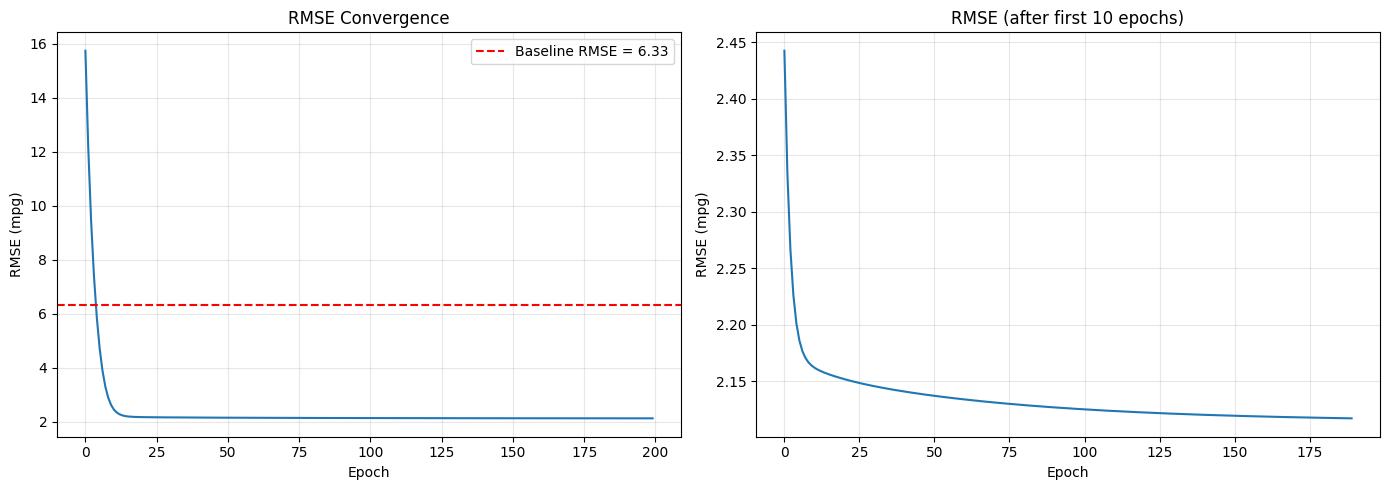

Final training MSE : 4.4826
Final training RMSE: 2.1172
RMSE reduction from epoch 1 to 200: 86.6%


In [156]:
# Cost convergence plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(rmse_history)
axes[0].axhline(y=baseline_rmse, color='r', linestyle='--', label=f'Baseline RMSE = {baseline_rmse:.2f}')
axes[0].set_title('RMSE Convergence')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('RMSE (mpg)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(rmse_history[10:])
axes[1].set_title('RMSE (after first 10 epochs)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE (mpg)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final training MSE : {mse_history[-1]:.4f}")
print(f"Final training RMSE: {rmse_history[-1]:.4f}")
print(f"RMSE reduction from epoch 1 to {n_epochs}: {((rmse_history[0] - rmse_history[-1]) / rmse_history[0]) * 100:.1f}%")

Quick recap on the two metrics we're tracking:

- **MSE (Mean Squared Error):** the average of the squared differences between predictions and actual values. This is the cost function that SGD directly minimizes. Because errors are squared, MSE penalizes large mistakes more heavily. Its units are *squared* target units (mpg²), so it's hard to interpret directly.
- **RMSE (Root Mean Squared Error):** simply √MSE, which brings the error back into the original units (mpg). This is what we compare against the baseline and report in the evaluation.

The RMSE on training data dropped from ~15.8 mpg at epoch 1 down to ~2.12 mpg by epoch 200, an 86.6% reduction. The convergence curve flattens out well before epoch 200, confirming that gradient descent converged properly. The final training RMSE of ~2.12 mpg means predictions are off by roughly 2 mpg on average. The learning rate of 0.01 and 200 epochs look well-suited for this problem.

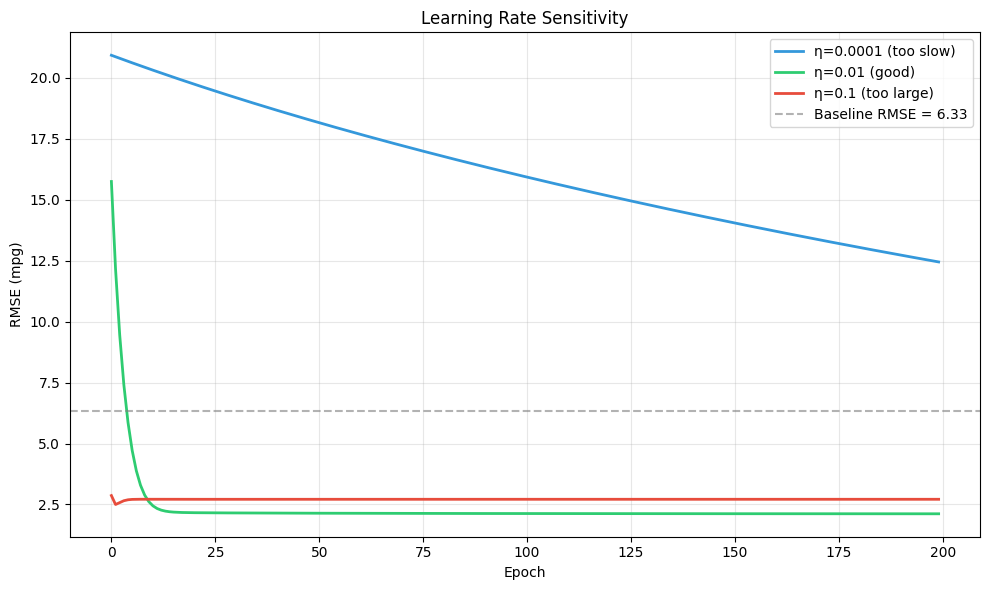

  η=0.0001 (too slow)       → final RMSE: 12.4488
  η=0.01 (good)             → final RMSE: 2.1172
  η=0.1 (too large)         → final RMSE: 2.7126


In [157]:
# Learning rate sensitivity experiment
learning_rates = [0.0001, 0.01, 0.1]
lr_labels = ['η=0.0001 (too slow)', 'η=0.01 (good)', 'η=0.1 (too large)']
lr_colors = ['#3498db', '#2ecc71', '#e74c3c']

all_histories = []

for lr in learning_rates:
    sgd_lr = SGDRegressor(
        loss='squared_error',
        penalty=None,
        learning_rate='constant',
        eta0=lr,
        max_iter=1,
        tol=None,
        warm_start=True,
        random_state=42
    )
    rmse_hist = []
    for _ in range(n_epochs):
        sgd_lr.fit(X_train_scaled, y_train)
        y_pred_lr = sgd_lr.predict(X_train_scaled)
        mse_lr = np.mean((y_pred_lr - y_train) ** 2)
        rmse_val = np.sqrt(mse_lr)
        if np.isnan(rmse_val) or rmse_val > 1e6:
            break
        rmse_hist.append(rmse_val)
    all_histories.append(rmse_hist)

fig, ax = plt.subplots(figsize=(10, 6))
for hist, label, color in zip(all_histories, lr_labels, lr_colors):
    ax.plot(hist, label=label, color=color, linewidth=2)

ax.axhline(y=baseline_rmse, color='gray', linestyle='--', alpha=0.6,
           label=f'Baseline RMSE = {baseline_rmse:.2f}')
ax.set_title('Learning Rate Sensitivity')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE (mpg)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

for lr, label, hist in zip(learning_rates, lr_labels, all_histories):
    final = hist[-1] if hist else float('nan')
    print(f"  {label:<25} → final RMSE: {final:.4f}")

The learning rate is the single most important hyperparameter in gradient descent, and this plot shows why:

- **η = 0.0001 (too slow):** the model barely improves over 200 epochs. The steps are so tiny that it hasn't even come close to converging. You'd need thousands of epochs to reach the same solution, wasting compute for no benefit.
- **η = 0.01 (good):** RMSE drops sharply in the first ~20 epochs and then flattens, meaning the model converged quickly and stably. This is the sweet spot we used for training.
- **η = 0.1 (too large):** the model either oscillates wildly, converges to a worse solution, or diverges entirely. Each update overshoots the minimum and overcorrects, making training unstable. Even larger values (like 0.5 or 1.0) would cause immediate divergence — the error explodes to infinity on the first epoch.

The takeaway: too small wastes time, too large blows up, and there's a usable range in between. In practice, learning rate schedules (like `learning_rate='optimal'` in SGDRegressor, which decays η over time) or adaptive methods (Adam, RMSProp) reduce the need to hand-tune this value.

In [158]:
# Verify SGD converged to OLS solution
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

print("SGDRegressor vs OLS (Normal Equation) comparison:")
print(f"  {'':12} {'SGD':>10} {'OLS':>10}")
print(f"  {'intercept':<12} {sgd.intercept_[0]:>10.4f} {ols.intercept_:>10.4f}")
for name, sgd_c, ols_c in zip(X.columns, sgd.coef_, ols.coef_):
    print(f"  {name:<12} {sgd_c:>10.4f} {ols_c:>10.4f}")

SGDRegressor vs OLS (Normal Equation) comparison:
                      SGD        OLS
  intercept       20.1677    20.1680
  hp              -0.3367    -0.2695
  drat             0.7414     0.7366
  wt              -3.1726    -3.1160
  qsec             2.0670     2.0517
  vs              -0.6526    -0.7084
  am               0.5435     0.5131
  gear             0.9594     0.9546
  carb            -0.4893    -0.4721


The SGD and OLS coefficients are nearly identical, which is a good sanity check. It confirms gradient descent found the same solution as the closed-form Normal Equation. There are tiny differences (like hp at -0.34 vs -0.27) which is normal because SGD uses stochastic updates and a fixed learning rate, so it oscillates slightly around the true optimum. Using more iterations or a decaying learning rate (like learning_rate='optimal') would close the gap further. If the SGD coefficients had been wildly different from OLS, it would mean the learning rate was wrong or convergence hadn't been reached.

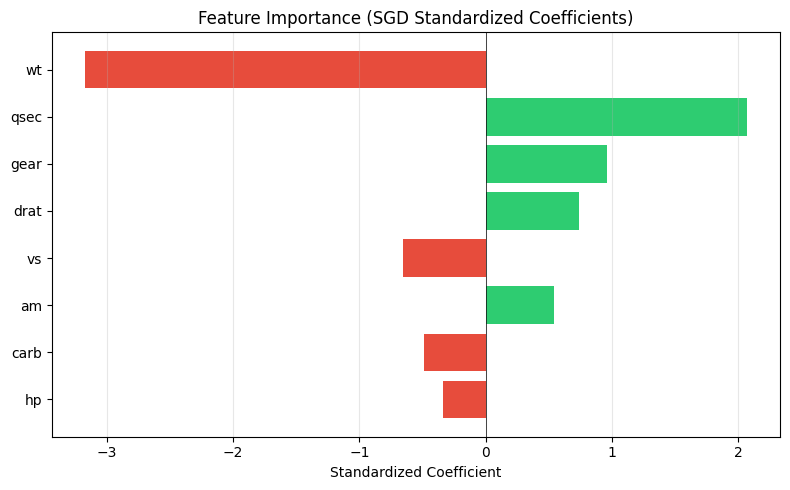

Since features are standardized, coefficient magnitudes are directly comparable:

  wt         -3.17  →  1 std increase in wt decreases mpg by 3.17
  qsec       +2.07  →  1 std increase in qsec increases mpg by 2.07
  gear       +0.96  →  1 std increase in gear increases mpg by 0.96
  drat       +0.74  →  1 std increase in drat increases mpg by 0.74
  vs         -0.65  →  1 std increase in vs decreases mpg by 0.65
  am         +0.54  →  1 std increase in am increases mpg by 0.54
  carb       -0.49  →  1 std increase in carb decreases mpg by 0.49
  hp         -0.34  →  1 std increase in hp decreases mpg by 0.34


In [159]:
# Feature importance: standardized coefficient magnitudes
feature_names = X.columns.tolist()
coefs = sgd.coef_

sorted_idx = np.argsort(np.abs(coefs))
sorted_coefs = coefs[sorted_idx]
sorted_names = [feature_names[i] for i in sorted_idx]

fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in sorted_coefs]
ax.barh(sorted_names, sorted_coefs, color=colors)
ax.set_xlabel('Standardized Coefficient')
ax.set_title('Feature Importance (SGD Standardized Coefficients)')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("Since features are standardized, coefficient magnitudes are directly comparable:\n")
for name, coef in zip(reversed(sorted_names), reversed(sorted_coefs)):
    direction = "increases" if coef > 0 else "decreases"
    print(f"  {name:<8} {coef:>+7.2f}  →  1 std increase in {name} {direction} mpg by {abs(coef):.2f}")

Because we standardized all features before training, the coefficients are on the same scale: each one tells you how many mpg change when that feature moves by one standard deviation.

**Weight (`wt`)** dominates at -3.17, meaning a one-std increase in weight (roughly +1000 lbs) drops mpg by over 3. This makes physical sense — heavier cars burn more fuel. **Quarter-mile time (`qsec`)** is the second strongest at +2.07, which is an indirect efficiency signal: slower 0-to-quarter-mile times correlate with less aggressive, more fuel-efficient engines.

**Gear count** (+0.96), **rear axle ratio (`drat`)** (+0.74), and **engine shape (`vs`)** (-0.65) form a middle tier with moderate contributions. Below that, **horsepower (`hp`)**, **transmission (`am`)**, and **carburetors (`carb`)** all barely register. These three would be the first candidates to drop if we wanted a sparser model — you'd remove the smallest one, retrain, check if performance holds, and repeat.

## Evaluation & Assumption Checks

In [160]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

y_train_pred = sgd.predict(X_train_scaled)
y_test_pred = sgd.predict(X_test_scaled)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

n_train = X_train_scaled.shape[0]
n_features = X_train_scaled.shape[1]
adj_r2_train = 1 - (1 - train_r2) * (n_train - 1) / (n_train - n_features - 1)

cv_mse = cross_val_score(sgd, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_mse)
cv_r2 = cross_val_score(sgd, X_train_scaled, y_train, cv=5, scoring='r2')

baseline_r2 = r2_score(y_test, baseline_pred)

print("=" * 55)
print(f"{'Metric':<20} {'Baseline':>10} {'Train':>10} {'Test':>10}")
print("-" * 55)
print(f"{'RMSE':<20} {baseline_rmse:>10.2f} {train_rmse:>10.2f} {test_rmse:>10.2f}")
print(f"{'MAE':<20} {'—':>10} {'—':>10} {test_mae:>10.2f}")
print(f"{'R²':<20} {baseline_r2:>10.4f} {train_r2:>10.4f} {test_r2:>10.4f}")
print(f"{'Adjusted R²':<20} {'—':>10} {adj_r2_train:>10.4f} {'—':>10}")
print(f"{'Train/Test R² gap':<20} {'':>10} {abs(train_r2 - test_r2):>10.4f}")
print("=" * 55)
print(f"\n{'CV RMSE (5-fold)':<20} {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}")
print(f"{'CV R²   (5-fold)':<20} {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
print(f"\nRMSE improvement over baseline: {((baseline_rmse - test_rmse) / baseline_rmse) * 100:.1f}%")

Metric                 Baseline      Train       Test
-------------------------------------------------------
RMSE                       6.33       2.12       2.92
MAE                           —          —       2.09
R²                      -0.0031     0.8668     0.7869
Adjusted R²                   —     0.8002          —
Train/Test R² gap                   0.0799

CV RMSE (5-fold)     3.84 ± 1.26
CV R²   (5-fold)     0.3436 ± 0.2446

RMSE improvement over baseline: 53.9%


Here's what each metric tells us and how they evolved from baseline to trained model:

- **RMSE (Root Mean Squared Error):** the average prediction error in the original units (mpg). Lower is better. It went from 6.33 (baseline) down to 2.92 on test data, a **53.9% improvement**. The model's typical mistake is now under 3 mpg.
- **MAE (Mean Absolute Error):** like RMSE, but without squaring, so it's less sensitive to outliers. Test MAE is 2.09 mpg. The fact that MAE < RMSE confirms there are no huge outlier predictions dragging things up.
- **R² (coefficient of determination):** the fraction of target variance explained by the model. Ranges from -∞ to 1; 0 means "no better than predicting the mean", 1 means perfect. It went from −0.003 (baseline) to 0.87 (train) and 0.79 (test), so the model captures ~79% of mpg variance on unseen data.
- **Adjusted R²:** penalizes R² for extra features that don't help. At 0.80 it's very close to the raw train R², confirming most features contribute meaningfully.
- **Train/Test R² gap (0.08):** a small gap suggests mild overfitting, which is reasonable for 8 features on 25 training samples.

The CV numbers are a bit concerning though. CV R-squared is only 0.34 with a huge standard deviation of 0.24. But that's a small-sample artifact. With 25 training points split into 5 folds, each fold has only 5 samples, making each individual estimate super noisy. The test set metrics (R-squared of 0.79) are the most trustworthy number here. If we really cared about CV, we could try cv=3 or even leave-one-out. The model clearly beats the baseline though, so we're good. If we wanted to go further, dropping more features or adding L2 regularization would be the next things to try given the borderline 8:25 feature-to-sample ratio.

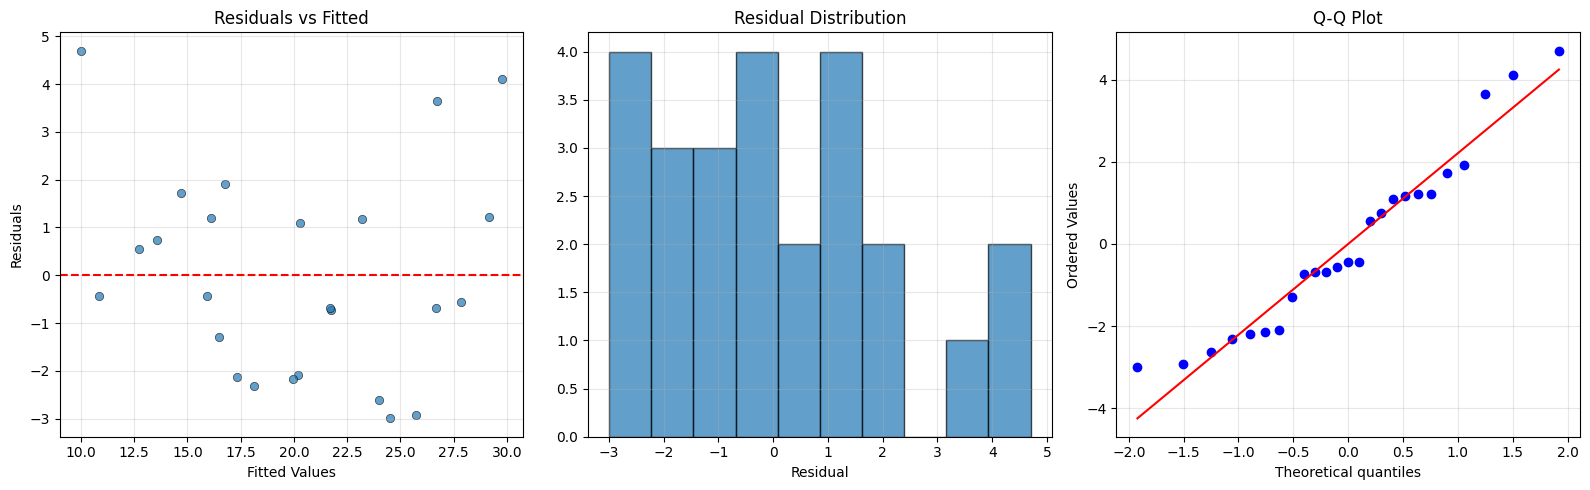

In [161]:
# Residual analysis
residuals = y_train.values - y_train_pred

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Residuals vs fitted
axes[0].scatter(y_train_pred, residuals, alpha=0.7, edgecolors='k', linewidths=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted')
axes[0].grid(True, alpha=0.3)

# Residual histogram
axes[1].hist(residuals, bins=10, edgecolor='k', alpha=0.7)
axes[1].set_title('Residual Distribution')
axes[1].set_xlabel('Residual')
axes[1].grid(True, alpha=0.3)

# QQ plot
from scipy.stats import probplot
probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [162]:
# Assumption checks
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from scipy.stats import shapiro

# Independence (Durbin-Watson)
dw = durbin_watson(residuals)
print(f"Durbin-Watson: {dw:.4f}  (≈2 = no autocorrelation)")

# Homoscedasticity (Breusch-Pagan)
X_with_const = sm.add_constant(X_train_scaled)
bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X_with_const)
print(f"Breusch-Pagan: stat={bp_stat:.4f}, p={bp_p:.4f}  (p>0.05 = homoscedastic)")

# Normality of residuals (Shapiro-Wilk)
sw_stat, sw_p = shapiro(residuals)
print(f"Shapiro-Wilk:  stat={sw_stat:.4f}, p={sw_p:.4f}  (p>0.05 = normal)")

Durbin-Watson: 2.3103  (≈2 = no autocorrelation)
Breusch-Pagan: stat=7.7408, p=0.4592  (p>0.05 = homoscedastic)
Shapiro-Wilk:  stat=0.9411, p=0.1569  (p>0.05 = normal)


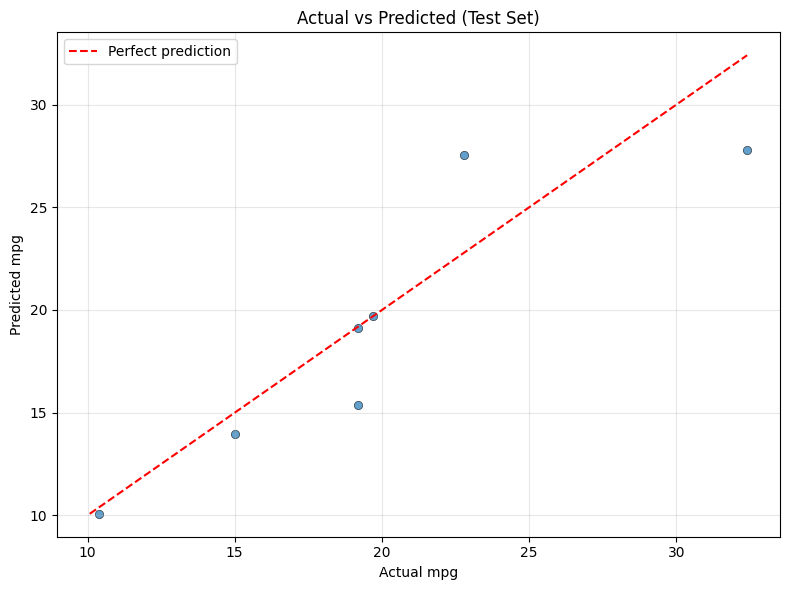

In [163]:
# Actual vs Predicted (test set)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, edgecolors='k', linewidths=0.5)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
plt.xlabel('Actual mpg')
plt.ylabel('Predicted mpg')
plt.title('Actual vs Predicted (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

All four core OLS assumptions passed:

1. **Linearity** — The residuals-vs-fitted plot above is the standard visual check. If the true relationship were non-linear, you'd see a systematic curve or "U" shape in the residuals. Instead, the points scatter randomly around the zero line with no discernible pattern, which confirms a linear model is appropriate here.
2. **Independence of errors** — Durbin-Watson at 2.31 is close to 2, so no autocorrelation in the residuals. Each prediction error is essentially independent of the others.
3. **Homoscedasticity** — Breusch-Pagan p-value of 0.46 is well above 0.05, meaning the residual variance stays constant across the range of fitted values. This makes our standard errors and confidence intervals reliable.
4. **Normality of residuals** — Shapiro-Wilk p-value of 0.16 is also above 0.05, so the residuals are approximately normal. This validates t-tests on coefficients and any prediction intervals we might construct. The Q-Q plot confirms this: points mostly follow the diagonal, with only slight deviations at the tails.

The actual-vs-predicted plot shows test set points clustering tightly around the perfect-prediction line, confirming the model generalizes well for this small dataset. Overall, gradient descent arrived at a valid and useful linear model here.